In [24]:
!pip install transformers -q
!pip install scikit-learn -q

# Memes (images) classification Based on Text


In [47]:
import json
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and shuffle dataset
data_path = "/content/drive/MyDrive/Dataset/final_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

device

device(type='cuda')

In [48]:
random.shuffle(data)

# Convert to DataFrame
df = pd.DataFrame(data)

# Split dataset 70% train, 15% val, 15% test with stratify
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1491, Val: 320, Test: 320


## Dataset for text only

In [49]:
# Dataset for text only
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        text = item['text']
        label = torch.tensor(item['label'], dtype=torch.long)

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)         # [seq_len]
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

## Training function

In [50]:
# Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

## Validation function

In [51]:
# Validation function
def eval_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return total_loss / len(dataloader), correct / total, all_preds, all_labels

## Prediction function for sample display

In [52]:
# Prediction function for sample display
def predict_sample(model, tokenizer, sample_text):
    model.eval()
    encoding = tokenizer(
        sample_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    return pred

## Initialize models and tokenizers

In [53]:
# Initialize models and tokenizers
models_info = [
    ("bert-base-multilingual-cased", "mBERT"),
    ("ai4bharat/indic-bert", "IndicBERT")
]

results = {}

num_epochs = 6
batch_size = 16
max_length = 128



Training mBERT model...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6: Train Loss: 0.6568, Train Acc: 0.5869, Val Loss: 0.5831, Val Acc: 0.7156
Epoch 2/6: Train Loss: 0.4826, Train Acc: 0.7646, Val Loss: 0.4376, Val Acc: 0.8094
Epoch 3/6: Train Loss: 0.3273, Train Acc: 0.8551, Val Loss: 0.5481, Val Acc: 0.7781
Epoch 4/6: Train Loss: 0.2008, Train Acc: 0.9195, Val Loss: 0.4908, Val Acc: 0.8156
Epoch 5/6: Train Loss: 0.1141, Train Acc: 0.9504, Val Loss: 0.6590, Val Acc: 0.7719
Epoch 6/6: Train Loss: 0.0867, Train Acc: 0.9624, Val Loss: 0.6298, Val Acc: 0.8219

Test Loss: 0.6299, Test Accuracy: 0.8250

Classification Report for mBERT:

              precision    recall  f1-score   support

           0     0.7737    0.9187    0.8400       160
           1     0.9000    0.7312    0.8069       160

    accuracy                         0.8250       320
   macro avg     0.8368    0.8250    0.8234       320
weighted avg     0.8368    0.8250    0.8234       320



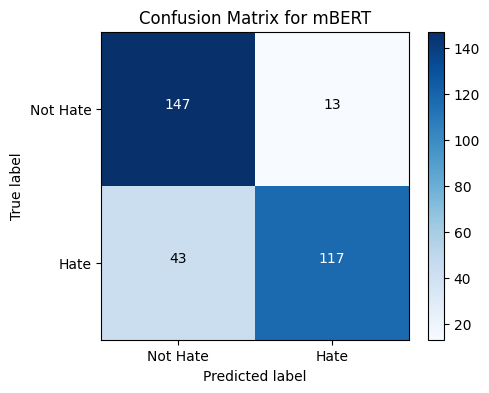



Training IndicBERT model...



config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Epoch 1/6: Train Loss: 0.6877, Train Acc: 0.5191, Val Loss: 0.6912, Val Acc: 0.5375
Epoch 2/6: Train Loss: 0.6768, Train Acc: 0.5734, Val Loss: 0.6521, Val Acc: 0.5969
Epoch 3/6: Train Loss: 0.6474, Train Acc: 0.5956, Val Loss: 0.6432, Val Acc: 0.5750
Epoch 4/6: Train Loss: 0.6009, Train Acc: 0.6808, Val Loss: 0.6052, Val Acc: 0.6500
Epoch 5/6: Train Loss: 0.5067, Train Acc: 0.7693, Val Loss: 0.4733, Val Acc: 0.7625
Epoch 6/6: Train Loss: 0.4109, Train Acc: 0.8249, Val Loss: 0.4814, Val Acc: 0.7250

Test Loss: 0.4755, Test Accuracy: 0.7594

Classification Report for IndicBERT:

              precision    recall  f1-score   support

           0     0.6986    0.9125    0.7913       160
           1     0.8739    0.6062    0.7159       160

    accuracy                         0.7594       320
   macro avg     0.7862    0.7594    0.7536       320
weighted avg     0.7862    0.7594    0.7536       320



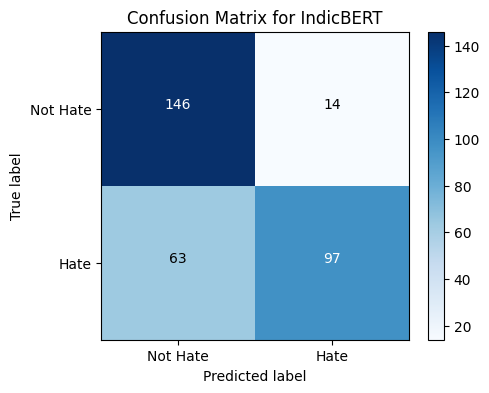

In [54]:
for model_name, label in models_info:
    print(f"\n\nTraining {label} model...\n")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    train_dataset = TextDataset(train_df, tokenizer, max_length=max_length)
    val_dataset = TextDataset(val_df, tokenizer, max_length=max_length)
    test_dataset = TextDataset(test_df, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = train_epoch(model, train_loader, optimizer, criterion)
        v_loss, v_acc, _, _ = eval_model(model, val_loader, criterion)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        train_accuracies.append(t_acc)
        val_accuracies.append(v_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

    # Save the trained model
    save_path = f"/content/drive/MyDrive/models/{label}_text_model"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # Evaluate on test set
    test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, criterion)

    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Classification report
    print(f"\nClassification Report for {label}:\n")
    print(classification_report(test_labels, test_preds, digits=4))

    # Confusion matrix plot
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {label}")
    plt.colorbar()
    plt.xticks([0,1], ['Not Hate', 'Hate'])
    plt.yticks([0,1], ['Not Hate', 'Hate'])
    thresh = cm.max() / 2.
    for i, j in ((i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    results[label] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'model_path': save_path,
        'tokenizer': tokenizer,
        'model': model
    }

## Plot validation accuracy comparison

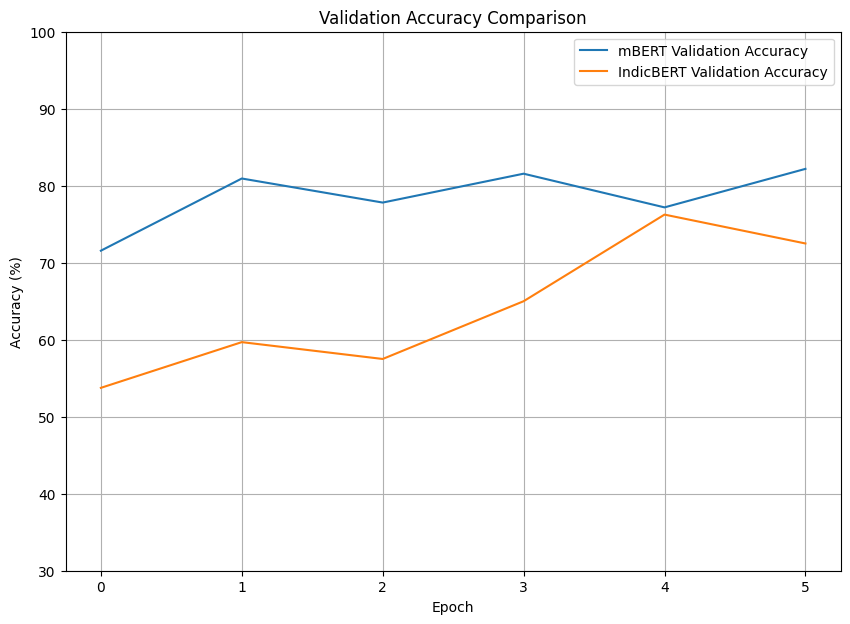

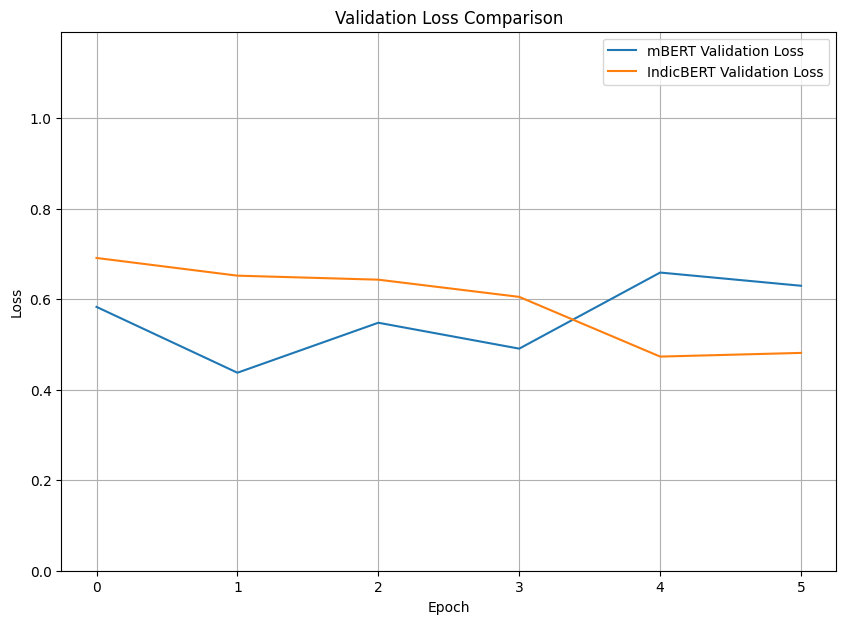

In [56]:
# Plot validation accuracy comparison with y-axis range 30%-100%
plt.figure(figsize=(10,7))
for label, res in results.items():
    plt.plot([a * 100 for a in res['val_accuracies']], label=f"{label} Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(30, 100)  # y-axis range from 30% to 100%
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss comparison with y-axis range set appropriately
plt.figure(figsize=(10,7))
for label, res in results.items():
    plt.plot(res['val_losses'], label=f"{label} Validation Loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Optional: set y limit from 0 to max loss + 0.5 margin for clarity
max_loss = max(max(res['val_losses']) for res in results.values())
plt.ylim(0, max_loss + 0.5)

plt.legend()
plt.grid(True)
plt.show()


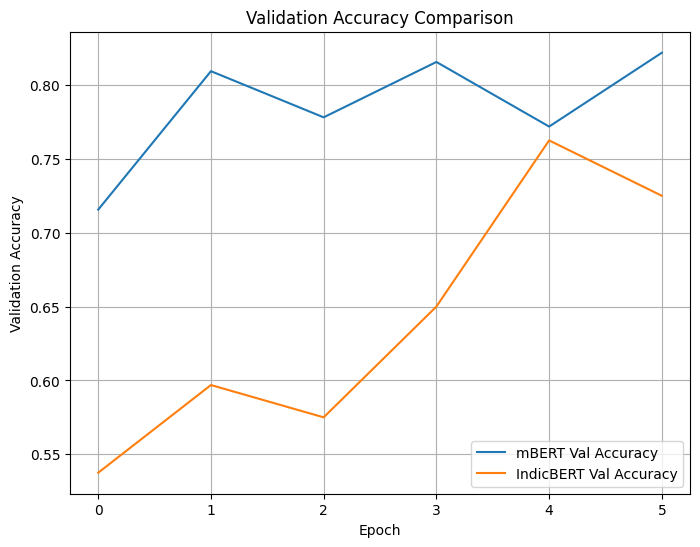

In [57]:
# Plot validation accuracy comparison
plt.figure(figsize=(8,6))
for label, res in results.items():
    plt.plot(res['val_accuracies'], label=f"{label} Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Randomly select 10 indices without replacement


Sample predictions on random test data with images:



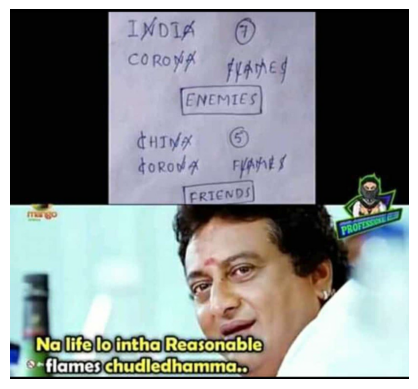

Text: its 60 india corona enemies china doroda evanes friends na life lo intha reasonable flames chudledhamma
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


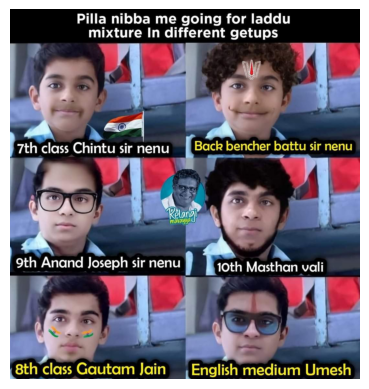

Text: pilla nibba me going for laddu mixture in different getups 7th class chintu sir nenu back bencher battu sir nenu relangs 9th anand joseph sir nenu 10th masthan vali 8th class gautam jain english medium umesh
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


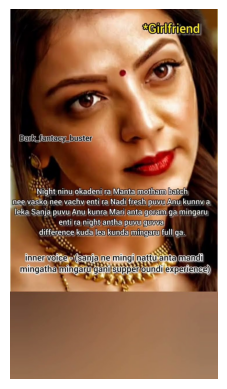

Text: darkfantacybuster girlfriend night ninu okadeni ra manta motham batch nee vako nee vachy enti ra nadij fresh puvu anu kunnv a leka sanja puvu anu kunra marijanta goram ga mingaru enti ra night antha puvu guwa difference kuda lea kunda mingaru fulliga inner voice sanja ne mingi nattu anta mandi mingatha mingaru gani supper foundi experience
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 0
----------------------------------------


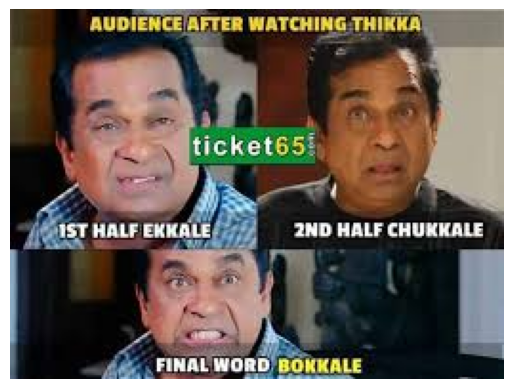

Text: audienceseller watching thikka 1st half enkale 3nd half chukkale final word bokkale
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


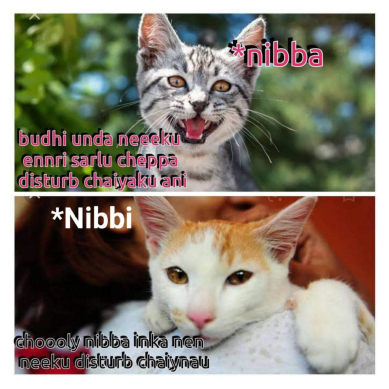

Text: budhi unda neeku ennri sarlu cheppa disturb chaiyaku ani nibbl choooly nibba inka nen neeku disturb chaiynau nibba
Actual Label: 0
Predicted by mBERT: 1
Predicted by IndicBERT: 0
----------------------------------------


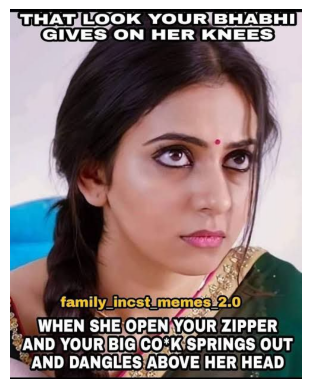

Text: that look yourbhabhi gives on her knees familyincstmemes 20 when she open your zipper and your big co k springs out and dangles above her head
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


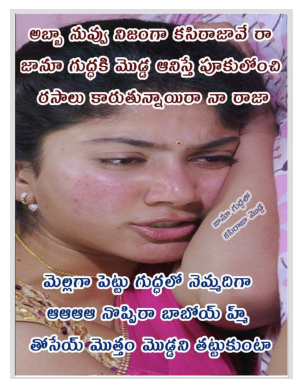

Text: అబ్బా నువ్వు నిజంగా కసిరాజావే జానూ గుద్దకి మొడ్డ అదిస్తే పూకులోంచి రసాలు కారుతున్నాయిరా నా రాజా న గుద్దలో మెల్లగా పెట్టు గుద్దలో నెమ్మదిగా ఆఆఆఆ నొప్పిరా బాబోయ్ హ్మ తోసేయ్ మొత్తం మొడ్డని తట్టుకుంటా
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


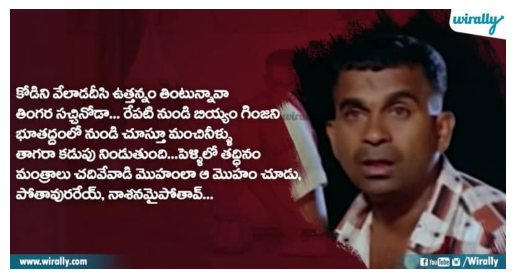

Text: కోడివి వేలాడదీ తింగర స కాలు చదివేవా
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


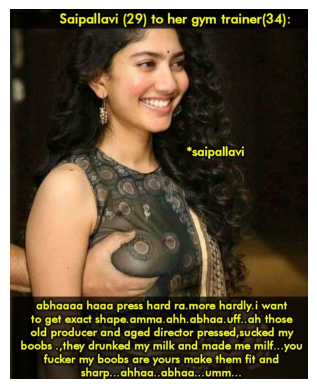

Text: saipallavi 29 to her gym trainer34 saipallavi abhaaaa haaa press hard ramore hardlyi want to got exact shapeammaahhabhaauffah those old producer and aged director pressed sucked my boobs they drunked my milk and mademo milfyou fucker my boobs are yours make them fit and sharpahhaaabhaaumm
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


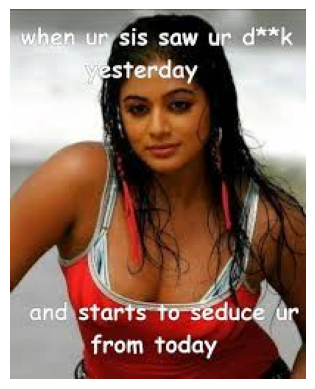

Text: sis saw esto lay starts to seduc from today
Actual Label: 1
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


In [65]:
import random

print("\nSample predictions on random test data with images:\n")

# Randomly select 10 indices without replacement
random_indices = random.sample(range(len(test_df)), 10)

for idx in random_indices:
    sample = test_df.iloc[idx]
    img = Image.open(sample['img']).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(f"Text: {sample['text']}")
    print(f"Actual Label: {sample['label']}")

    for label, res in results.items():
        pred = predict_sample(res['model'], res['tokenizer'], sample['text'])
        print(f"Predicted by {label}: {pred}")
    print("----"*10)


## Load saved model and test it

In [67]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import random
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
# List of your models info (model_name and label)
models_info = [
    ("bert-base-multilingual-cased", "mBERT"),
    ("ai4bharat/indic-bert", "IndicBERT")
]

# Load saved models and tokenizers from drive
results = {}
for model_name, label in models_info:
    print(f"Loading {label} model from Drive...")
    save_path = f"/content/drive/MyDrive/models/{label}_text_model"
    tokenizer = AutoTokenizer.from_pretrained(save_path)
    model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)

    results[label] = {
        'model': model,
        'tokenizer': tokenizer
    }
print("Models loaded Successfully! ")

Loading mBERT model from Drive...
Loading IndicBERT model from Drive...
Models loaded Successfully! 


In [70]:
# Prediction helper function
def predict_sample(model, tokenizer, sample_text):
    model.eval()
    encoding = tokenizer(
        sample_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    return pred


Sample predictions on random test data with images:



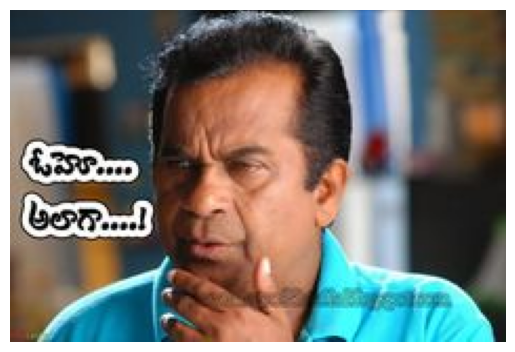

Text: అలాగా
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


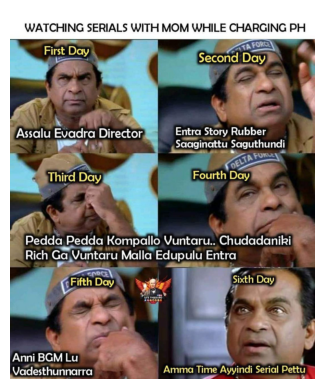

Text: watching serials with mom while charging ph first day second day assalu evadra director entra story rubber third day saaginattu saguthundi fourth day furu delta pedda pedda kompallo vuntaru chudadaniki rich ga vuntaru malla edupulu entra fifth day sixth day lite the suro anni bgm lu vadesthunnarra amma time ayyindi serial pettu
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


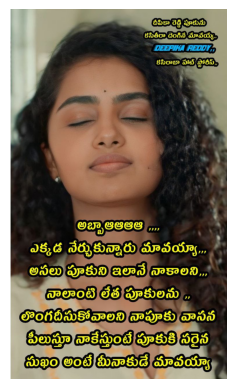

Text: దీపికా రెడ్డి పూకును కసితీరా దెంగిన మావయ్య deepika reddy కసిరాజా హాట్ స్టోరీస్ అబ్బాఆఆఆఆ ఎక్కడ నేర్చుకున్నారు మావయ్యా అసలు పూకుని ఇలానే నాకాలని నాలాంటి లేత పూకులను లొంగదీసుకోవాలని నాపూకు వాసన పిలుస్తూ నాకేస్తుంటే పూకుకి సరైన సుఖం అంటే మీనాకుడే మావయ్యా
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


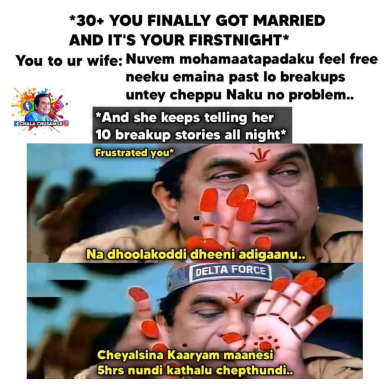

Text: 30 you finally got married and its your firstnight you to ur wife nuvem mohamaatapadaku feel free neeku emaina past lo breakups untey cheppu naku no problem chala chusamleo and she keeps telling her 10 breakup stories all night frustrated you na dhoolakoddi dheeni adigaanu delta force cheyalsina kaaryam maanesi 5hrs nundi kathalu chepthundi
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


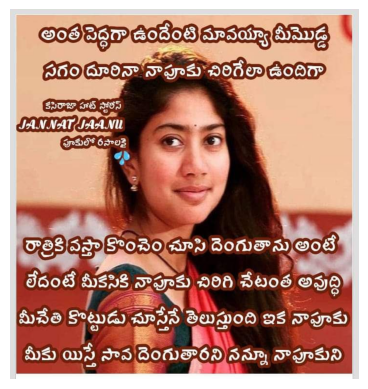

Text: అంత పెద్దగా ఉందేంటి మావయ్యా మీమొడ్డ సగం దూరినా నాపూకు చిరిగేలా ఉందిగా కసిరాజా హాట్ స్టోరీస్ jan nat jaanu పూకులో రసాలకై రాత్రికి వస్తా కొంచెం చూసి దెంగుతాను అంటే లేదంటే మీకసికి నాపూకు చిరిగి చేటంత అవుద్ధి మీచేతి కొట్టుడు చూస్తేనే తెలుస్తుంది ఇక నాపూకు మీకు యిస్తే సావ దెంగుతారని నన్నూ నాపూకుని
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


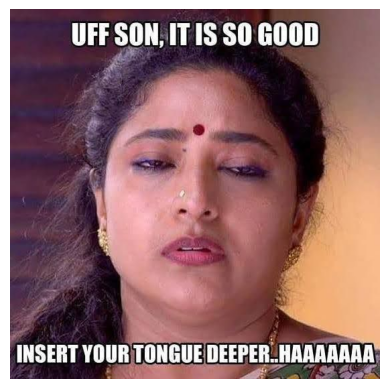

Text: uff son it is so good insert your tongue deeper haaaaaaa
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 1
----------------------------------------


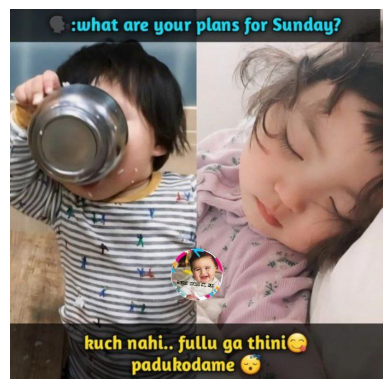

Text: what are your plans for sunday dne z dz kuch nahi fullu ga thinie padukodame
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


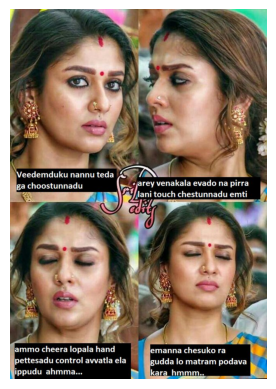

Text: veedemduku nannu teda ga choostunnadu arey venakala evado na pirra lani touch chestunnadu emti 113 ammo cheera lopala hand pettesadu control avvatla ela ippudu ahmma emanna chesuko ra gudda lo matram podava kara hmmm
Actual Label: 1
Predicted by mBERT: 1
Predicted by IndicBERT: 0
----------------------------------------


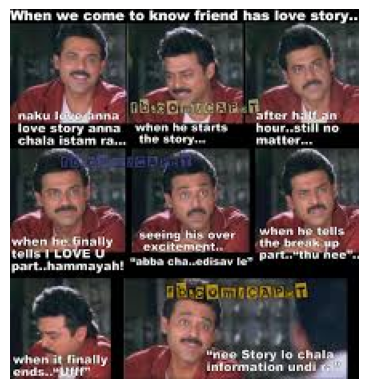

Text: when we come to know friend has love story itve story are when man chala letam ra the story maiter rruedved parthummayak
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 0
----------------------------------------


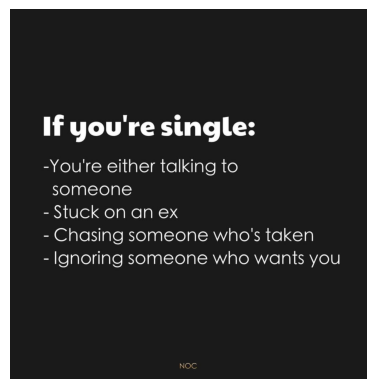

Text: if youre single youte either tlking to someone stuck on an ex chosing someone whos taken ignoring someone who wants you inog
Actual Label: 0
Predicted by mBERT: 0
Predicted by IndicBERT: 1
----------------------------------------


In [71]:
# Sample 10 random images from test_df and predict
print("\nSample predictions on random test data with images:\n")
random_indices = random.sample(range(len(test_df)), 10)

for idx in random_indices:
    sample = test_df.iloc[idx]
    img = Image.open(sample['img']).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(f"Text: {sample['text']}")
    print(f"Actual Label: {sample['label']}")

    for label, res in results.items():
        pred = predict_sample(res['model'], res['tokenizer'], sample['text'])
        print(f"Predicted by {label}: {pred}")
    print("----"*10)


In [72]:
import nbformat

# Load the current notebook
notebook_path = "/content/drive/MyDrive/Colab Notebooks/Final_text_only_models.ipynb"  # Change this
notebook = nbformat.read(notebook_path, as_version=nbformat.NO_CONVERT)

# Remove invalid 'widgets' metadata
if 'widgets' in notebook['metadata']:
    del notebook['metadata']['widgets']

# Re-save the cleaned notebook
nbformat.write(notebook, notebook_path)

print("Fixed and saved the notebook successfully.")


Fixed and saved the notebook successfully.
